In [1]:
import pandas as pd
import sqlite3 
import pytz
import datetime
tz = pytz.timezone('UTC')
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

In [2]:
def get_cnts_pcts(series):
    cnts = series.value_counts()
    pcts = 100*series.value_counts(normalize=True).round(5)
    combo = pd.concat({"Count":cnts, "Percent": pcts}, axis=1)
    return(combo)


In [3]:
con = sqlite3.connect('/home/malcolm/petfinder/data/petfinder.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('dog_10475_30mi',), ('cat_10475_30mi',), ('Organizations',), ('Dog_Image_Status',)]


In [4]:
cursor.execute("""
select min(date_saved), max(date_saved), count(*)
from dog_10475_30mi
""").fetchall()

[('2021-07-03', '2021-11-07', 299237)]

In [5]:
n_dogs = cursor.execute("""
select date_saved, count(*) as cnt_dogs
, count(distinct id) as cnt_uniqueids
from dog_10475_30mi
group by date_saved
order by 1 desc
limit 30
""").fetchall()
n_dogs

[('2021-11-07', 2397, 2397),
 ('2021-11-06', 2432, 2428),
 ('2021-11-05', 2426, 2422),
 ('2021-11-04', 2411, 2411),
 ('2021-11-03', 2376, 2373),
 ('2021-11-02', 2383, 2383),
 ('2021-11-01', 2355, 2355),
 ('2021-10-31', 2384, 2384),
 ('2021-10-30', 2448, 2448),
 ('2021-10-29', 2415, 2412),
 ('2021-10-28', 2411, 2411),
 ('2021-10-27', 2319, 2318),
 ('2021-10-26', 2298, 2298),
 ('2021-10-25', 2305, 2304),
 ('2021-10-24', 2320, 2318),
 ('2021-10-23', 2333, 2329),
 ('2021-10-22', 2339, 2336),
 ('2021-10-21', 2334, 2330),
 ('2021-10-20', 2318, 2318),
 ('2021-10-19', 2319, 2319),
 ('2021-10-18', 2320, 2318),
 ('2021-10-17', 2321, 2319),
 ('2021-10-16', 2403, 2400),
 ('2021-10-15', 2416, 2416),
 ('2021-10-14', 2394, 2394),
 ('2021-10-13', 2370, 2368),
 ('2021-10-12', 2347, 2347),
 ('2021-10-11', 2350, 2350),
 ('2021-10-10', 2383, 2382),
 ('2021-10-09', 2438, 2436),
 ('2021-10-08', 2460, 2453),
 ('2021-10-07', 2435, 2433),
 ('2021-10-06', 2422, 2420),
 ('2021-10-05', 2396, 2396),
 ('2021-10-04'

In [97]:
today = datetime.datetime.now()
today_str = str(datetime.datetime.now().date())
two_weeks = today - datetime.timedelta(days=21)
two_weeks_str = str(two_weeks.date())

In [101]:
sql2 = f"""

with two_weeks_dogs as (
select id as id_old
, status as status_old
, status_changed_at as status_change_old
, date_saved as date_saved_old
from dog_10475_30mi
where date_saved = '{two_weeks_str}'
) , 
today_dogs as (
select id as id_new
, status as status_new
, status_changed_at as status_change_new
, date_saved as date_saved_new
from dog_10475_30mi
where date_saved = '{today_str}'
)


select count(*)
, count(distinct id_new) as unique_new_dogs
, count(distinct id_old) as unique_old_dogs
, sum(case when id_old is null then 1 else 0 end) as new_dogs -- Old doesn't have key so dog must be new
, sum(case when id_new is null then 1 else 0 end) as old_dogs -- New doesn't have key so dog must be old 
, sum(case when id_old is not null and id_new is not null then 1 else 0 end) as still_there_dogs
, min(date_saved_old) as start_date
, max(date_saved_new) as end_date

from (
SELECT id_new, status_new, status_change_new, date_saved_new
, id_old, status_old, status_change_old, date_saved_old
from two_weeks_dogs
left join today_dogs
on two_weeks_dogs.id_old = today_dogs.id_new

UNION 

SELECT id_new, status_new, status_change_new, date_saved_new
, id_old, status_old, status_change_old, date_saved_old
from today_dogs 
left join two_weeks_dogs
on today_dogs.id_new = two_weeks_dogs.id_old
)x

"""

demo1 = pd.read_sql(sql2, con)
demo1

,count(*),unique_new_dogs,unique_old_dogs,new_dogs,old_dogs,still_there_dogs,start_date,end_date
0,3236,2443,2330,906,793,1537,2021-10-21,2021-11-11


In [7]:
data_raw = pd.read_sql(f"""
select dogs.*, orgs.name as org_name 
from dog_10475_30mi dogs
left join Organizations orgs
on dogs.organization_id = orgs.id
where date_saved between '{two_weeks_str}' and '{today_str}'
""" , con)
data_raw['published_at'] = pd.to_datetime(data_raw['published_at'])
data_raw['status_changed_at'] = pd.to_datetime(data_raw['status_changed_at'])
data_raw['date_saved'] = pd.to_datetime(data_raw['date_saved'], utc=True)

data = data_raw[data_raw['date_saved'] == data_raw['date_saved'].max()]
print(data.shape)
data.head()

(2397, 51)


,id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,organization_animal_id,photos,videos,status,status_changed_at,published_at,distance,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,primary_photo_cropped.small,primary_photo_cropped.medium,primary_photo_cropped.large,primary_photo_cropped.full,contact.email,contact.phone,contact.address.address1,contact.address.address2,contact.address.city,contact.address.state,contact.address.postcode,contact.address.country,animal_id,animal_type,primary_photo_cropped,date_saved,org_name
16767,53492780,NY1537,https://www.petfinder.com/dog/raja-53492780/ny/brooklyn/small-bites-rescue-inc-ny1537/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Baby,Male,Large,Short,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",Raja,None,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 []\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-11-07 05:03:43+00:00,2021-11-07 05:03:43+00:00,13.6441,Pit Bull Terrier,None,0,0,Red / Chestnut / Orange,None,None,0,0,None,0,1,1.0,1.0,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53492780/1/?bust=1636261421&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53492780/1/?bust=1636261421&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53492780/1/?bust=1636261421&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53492780/1/?bust=1636261421,smallbitesrescueinc@gmail.com,None,None,None,Brooklyn,NY,11221,US,53492780,dog,None,2021-11-07 00:00:00+00:00,Small Bites Rescue Inc
16768,53220915,NY1545,https://www.petfinder.com/dog/melody-53220915/ny/floral-park/keep-me-warm-doghouses-inc-ny1545/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Young,Female,Small,Medium,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",Melody,Melody is the sweetest dog! She playful and loves her humans and dog friend at her foster home. Melody is...,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 []\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-11-07 03:57:14+00:00,2021-11-07 03:57:14+00:00,12.1493,Corgi,Jindo,1,0,White / Cream,None,None,1,1,None,0,1,1.0,1.0,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53220915/1/?bust=1636257431&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53220915/1/?bust=1636257431&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53220915/1/?bust=1636257431&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53220915/1/?bust=1636257431,suekmwdadoptions@gmail.com,None,None,None,Floral Park,NY,11001,US,53220915,dog,None,2021-11-07 00:00:00+00:00,"Keep Me Warm Doghouses, Inc"
16769,53492320,NY245,https://www.petfinder.com/dog/manchita-53492320/ny/new-york/stray-from-the-heart-ny245/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Adult,Female,Medium,None,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",Manchita,Manchita is a beautiful girl who was rescued off the street with her two babies. Her babies got adopted but...,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 []\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,20

In [8]:
data_raw['id'].nunique()

2853

## Peak at some attributes

In [9]:
data.columns

Index(['id', 'organization_id', 'url', 'type', 'species', 'age', 'gender',
       'size', 'coat', 'tags', 'name', 'description', 'organization_animal_id',
       'photos', 'videos', 'status', 'status_changed_at', 'published_at',
       'distance', 'breeds.primary', 'breeds.secondary', 'breeds.mixed',
       'breeds.unknown', 'colors.primary', 'colors.secondary',
       'colors.tertiary', 'attributes.spayed_neutered',
       'attributes.house_trained', 'attributes.declawed',
       'attributes.special_needs', 'attributes.shots_current',
       'environment.children', 'environment.dogs', 'environment.cats',
       'primary_photo_cropped.small', 'primary_photo_cropped.medium',
       'primary_photo_cropped.large', 'primary_photo_cropped.full',
       'contact.email', 'contact.phone', 'contact.address.address1',
       'contact.address.address2', 'contact.address.city',
       'contact.address.state', 'contact.address.postcode',
       'contact.address.country', 'animal_id', 'animal_type',

In [10]:
data['status'].value_counts()

adoptable    2397
Name: status, dtype: int64

In [11]:
data['status_changed_at'] 
data['published_at'].min()

Timestamp('2010-01-17 00:00:00+0000', tz='UTC')

In [12]:
data[data['status_changed_at'] <= '2021-01-01'].shape
# Probably data quality issue.. should investigate or drop these records

(286, 51)

In [13]:
status_change = data[data['status_changed_at'] != data['published_at']]
status_change.shape

(320, 51)

In [14]:
status_change

,id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,organization_animal_id,photos,videos,status,status_changed_at,published_at,distance,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,primary_photo_cropped.small,primary_photo_cropped.medium,primary_photo_cropped.large,primary_photo_cropped.full,contact.email,contact.phone,contact.address.address1,contact.address.address2,contact.address.city,contact.address.state,contact.address.postcode,contact.address.country,animal_id,animal_type,primary_photo_cropped,date_saved,org_name
16948,53461770,NY1520,https://www.petfinder.com/dog/the-cheese-litter-53461770/ny/brooklyn/true-north-pet-rescue-mission-ny1520/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Baby,Male,Medium,Medium,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",The Cheese litter,NOTE: There are 3 border collie mix pups in the Cheese litter still available for adoption. They are 7-8 weeks...,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 []\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-11-04 10:14:01+00:00,2021-11-04 10:12:11+00:00,19.9039,Border Collie,None,1,0,Bicolor,None,None,1,0,None,0,0,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53461770/1/?bust=1636020723&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53461770/1/?bust=1636020723&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53461770/1/?bust=1636020723&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53461770/1/?bust=1636020723,TrueNorthRescue@gmail.com,None,None,None,Brooklyn,NY,11229,US,53461770,dog,None,2021-11-07 00:00:00+00:00,True North Pet Rescue Mission
17094,53430508,NY1520,https://www.petfinder.com/dog/bono-53430508/ny/brooklyn/true-north-pet-rescue-mission-ny1520/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Adult,Male,Small,Wire,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",Bono,Meet Bono! This terrier mix has just arrived from Texas and is settling into her foster home. This super sweet...,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 []\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-11-01 19:09:59+00:00,2021-11-01 19:05:14+00:00,19.9039,Terrier,None,1,0,Apricot / Beige,Yellow / Tan / Blond / Fawn,White / Cream,1,1,None,0,1,NaN,NaN,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53430508/1/?bust=1635773817&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53430508/1/?bust=1635773817&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53430508/1/?bust=1635773817&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/53430508/1/?bust=1635773817,TrueNorthRescue@gmail.com,None,None,None,Brooklyn,NY,11229,US,53430508,dog,None,2021-11-07 00:00:00+00:00,True North Pet Rescue Mission
17113,53430554,NY1520,https://www.petfinder.com/dog/forrest-53430554/ny/brooklyn/true-north-pet-rescue-mission-ny1520/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Senior,Male,Medium,Medium,"0 [Friendly, Playful, Smart, Curious, Affectionate]\n1 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n2 []\n3 ...",Forrest,"This handsome fella is Forrest, a lovable 8/9-year-old lab mix. Forrest is a rescue from Texas, where he likely gained...",None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k

In [15]:
status_change.status.value_counts()

adoptable    320
Name: status, dtype: int64

In [16]:
def summarize_dog_pop(df):
    
    out = {}
    out['Count'] = df.shape[0]
    
    def parse_cnts_pcts1(df, desc):
        dict1 = {f'Top {desc} Name': df.iloc[0].name, 
                 f'Top {desc} %' : df.iloc[0]['Percent'], 
                }
        return(dict1)
    
    def parse_cnts_pcts2(df, desc):
        dict1 = {f'2nd {desc} Name': df.iloc[1].name, 
                 f'2nd {desc} %' : df.iloc[1]['Percent'], 
                }
        return(dict1)
    
    breeds = get_cnts_pcts(df['breeds.primary'])
    breeds_dict1 = parse_cnts_pcts1(breeds, 'Breed')
    breeds_dict2 = parse_cnts_pcts2(breeds, 'Breed')

    age = get_cnts_pcts(df['age'])
    age_dict1 = parse_cnts_pcts1(age, 'Age')
    age_dict2 = parse_cnts_pcts2(age, 'Age')
    
    color = get_cnts_pcts(df['colors.primary'])
    color_dict1 = parse_cnts_pcts1(color, 'Color')
    color_dict2 = parse_cnts_pcts2(color, 'Color')
    
    
    children = get_cnts_pcts(df['environment.children'])
    children_dict1 = parse_cnts_pcts1(children, 'Children')
    children_dict2 = parse_cnts_pcts2(children, 'Children')
    
    housetrained = get_cnts_pcts(df['attributes.house_trained'])
    housetrained_dict1 = parse_cnts_pcts1(housetrained, 'House Trained')
    housetrained_dict2 = parse_cnts_pcts2(housetrained, 'House Trained')
    
    dog_friendly = get_cnts_pcts(df['environment.dogs'])
    dog_friendly_dict1 = parse_cnts_pcts1(dog_friendly, 'Dog Friendly')
    dog_friendly_dict2 = parse_cnts_pcts2(dog_friendly, 'Dog Friendly')
    
    out.update(breeds_dict1)
    out.update(age_dict1)
    out.update(color_dict1)
    out.update(children_dict1)
    out.update(housetrained_dict1)
    out.update(dog_friendly_dict1)
    out.update(breeds_dict2)
    
    out_series = pd.Series(out)
    return(out_series)

In [17]:
summary = summarize_dog_pop(data)
summary

Count                                   2397
Top Breed Name            Labrador Retriever
Top Breed %                           12.766
Top Age Name                           Adult
Top Age %                             42.762
Top Color Name                         Black
Top Color %                           23.297
Top Children Name                          1
Top Children %                        78.303
Top House Trained Name                     0
Top House Trained %                   59.032
Top Dog Friendly Name                      1
Top Dog Friendly %                    85.081
2nd Breed Name              Pit Bull Terrier
2nd Breed %                            12.39
dtype: object

In [18]:
data_raw = data_raw.sort_values('date_saved')
dedup_all_dogs = data_raw.drop_duplicates(subset=['id'])
dedup_all_dogs.shape

(2853, 51)

In [19]:
summary_raw = summarize_dog_pop(dedup_all_dogs)
summary_raw

Count                                   2853
Top Breed Name            Labrador Retriever
Top Breed %                           13.109
Top Age Name                           Adult
Top Age %                             40.834
Top Color Name                         Black
Top Color %                           23.193
Top Children Name                          1
Top Children %                        79.972
Top House Trained Name                     0
Top House Trained %                   60.358
Top Dog Friendly Name                      1
Top Dog Friendly %                    86.966
2nd Breed Name              Pit Bull Terrier
2nd Breed %                           11.427
dtype: object

In [20]:
breeds = get_cnts_pcts(data['breeds.primary'])
breeds.iloc[0].name

'Labrador Retriever'

In [21]:
get_cnts_pcts(data['colors.primary'])

,Count,Percent
Black,366,23.297
White / Cream,230,14.640
Brown / Chocolate,169,10.757
"Tricolor (Brown, Black, & White)",147,9.357
Yellow / Tan / Blond / Fawn,141,8.975
Apricot / Beige,99,6.302
Brindle,98,6.238
Bicolor,97,6.174
Gray / Blue / Silver,89,5.665
Red / Chestnut / Orange,76,4.838


In [22]:
get_cnts_pcts(data['age'])

,Count,Percent
Adult,1025,42.762
Young,650,27.117
Baby,508,21.193
Senior,214,8.928


In [23]:
get_cnts_pcts(data['attributes.house_trained'])

,Count,Percent
0,1415,59.032
1,982,40.968


In [24]:
get_cnts_pcts(data['environment.children'])
get_cnts_pcts(data['attributes.house_trained'])
get_cnts_pcts(data['environment.dogs'])

,Count,Percent
1.0,1306,85.081
0.0,229,14.919


In [25]:
get_cnts_pcts(data['environment.dogs'])

,Count,Percent
1.0,1306,85.081
0.0,229,14.919


In [26]:
org_value_counts = get_cnts_pcts(data['org_name'])
org_value_counts

,Count,Percent
Rescue Dogs Rock NYC,202,9.279
Second Chance Rescue,115,5.282
Ruff House Rescue,96,4.410
North Shore Animal League America,68,3.124
Town of Hempstead Animal Shelter,60,2.756
...,...,...
Near and Far Animal Foundation,1,0.046
Northeast Boston Terrier Rescue Inc.,1,0.046
Hopeful Tails Registered Rescue (at Dapper Dog),1,0.046
Bloomfield Animal Shelter - John A. Bukowski Shelter for Animals,1,0.046


In [27]:
# # of shelter with more than 10 dogs 
org_value_counts[org_value_counts['Count'] >= 10].shape[0]

59

<AxesSubplot:>

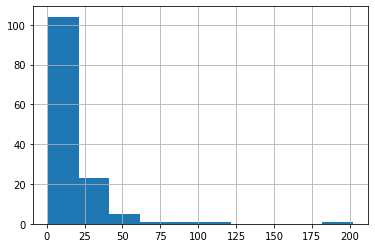

In [28]:
org_value_counts['Count'].hist()

In [29]:
data.iloc[1]

id                                                                                                                                                                                                                             53220915
organization_id                                                                                                                                                                                                                  NY1545
url                                                                                    https://www.petfinder.com/dog/melody-53220915/ny/floral-park/keep-me-warm-doghouses-inc-ny1545/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c
type                                                                                                                                                                                                                                Dog
species                                                                 

## Dog Status Change

In [30]:
def dog_days_gb_func(df, adopt_date=(datetime.datetime.now() - datetime.timedelta(days=1)).date()):
    
    df = df.sort_values('date_saved')
    
    out = {}
    out['Days in DB (yourdb)'] = (df['date_saved'].max() - df['date_saved'].min()).days
    out['Count'] = df.shape[0]
    out['Days ad posted'] = (df['date_saved'].max() - df['published_at'].min()).days
    adoptable_days = df[df['status'] == 'adoptable']
    out['Days adoptable'] = adoptable_days.shape[0]
    out['Last Adoptable Day'] = adoptable_days['date_saved'].max()
    
    out['Adopted (last status)'] = (df.iloc[-1].status != 'adoptable')
    out['Adopted (last date)'] = df.iloc[-1]['date_saved'] >= adopt_date 
    
    out_series = pd.Series(out)
    last_record = df.iloc[0]
    out_all = pd.concat([out_series, last_record]) 
    return(out_all)
    

In [31]:
dog_gb = data_raw.groupby('id').apply(dog_days_gb_func)
print("Shape: ", dog_gb.shape)
dog_gb

Shape:  (2853, 58)


,Days in DB (yourdb),Count,Days ad posted,Days adoptable,Last Adoptable Day,Adopted (last status),Adopted (last date),id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,organization_animal_id,photos,videos,status,status_changed_at,published_at,distance,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,primary_photo_cropped.small,primary_photo_cropped.medium,primary_photo_cropped.large,primary_photo_cropped.full,contact.email,contact.phone,contact.address.address1,contact.address.address2,contact.address.city,contact.address.state,contact.address.postcode,contact.address.country,animal_id,animal_type,primary_photo_cropped,date_saved,org_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15546918,7,8,4312,8,2021-11-07 00:00:00+00:00,False,True,15546918,NY769,https://www.petfinder.com/dog/buddy-15546918/ny/glen-head/shepherds-hope-rescue-ny769/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Young,Male,Medium,None,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n3 [Friendly, ...",Buddy,"Here&#039;s Buddy, an adorable 8 year old Shepherd mix. He was adopted from one of the city shelters to an...",825418,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 [{'embed': '<iframe title=""Video"" frameborder=...\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2010-01-17 20:48:17+00:00,2010-01-17 00:00:00+00:00,10.9750,Shepherd,None,1,0,None,None,None,1,1,None,0,1,0.0,0.0,0.0,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/15546918/3/?bust=1452873122&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/15546918/3/?bust=1452873122&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/15546918/3/?bust=1452873122&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/15546918/3/?bust=1452873122,toomanyshepherds@aol.com,None,None,None,Glen Head,NY,11545,US,15546918,dog,None,2021-10-31 00:00:00+00:00,None
25009612,7,8,3231,8,2021-11-07 00:00:00+00:00,False,True,25009612,NY955,https://www.petfinder.com/dog/franklin-25009612/ny/glen-cove/project-pet-inc-ny955/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Senior,Male,Medium,Short,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n3 [Friendly, ...",Franklin,PLEASE EMAIL: mbwambwa@icloud.com\nDIRECTLY TO FIND OUT HOW TO MEET THIS CUTIE!\n\nThis 8 year-old love muffin is summed up...,None,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 [{'embed': '<iframe title=""Video"" frameborder=...\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2014-09-29 20:37:01+00:00,2013-01-01 16:05:32+00:00,10.6483,Terrier,None,1,0,Yellow / Tan / Blond / Fawn,White / Cream,None,1,1,None,0,1,NaN,1.0,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/25009612/4/?bust=1533002011&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/25009612/4/?bust=1533002011&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/25009612/4/?bust=1533002011&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/25009612/4/?bust=1533002011,friends@projectpetinc.org,None,None,None,Glen Cove,NY,11542,US,25009612,dog,None,2021-10-31 00:00:00+00:00,None
25777517,7,8,3138,8,2021-11-07 00:00:00+00:00,False,True,25777517,NY977,https://www.petfinder.com/dog/italian-greyhound-place-25777517/ny/croton-on-hudson/italian-greyhound-place-ny977/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Adult,Male,Small,None,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\

In [32]:
dog_gb['Days in DB (yourdb)'].describe()

count    2853.000000
mean        5.719593
std         2.222832
min         0.000000
25%         5.000000
50%         7.000000
75%         7.000000
max         7.000000
Name: Days in DB (yourdb), dtype: float64

In [33]:
dog_gb['Days ad posted'].describe()

count    2853.000000
mean      169.446898
std       373.633049
min        -1.000000
25%        10.000000
50%        41.000000
75%       142.000000
max      4312.000000
Name: Days ad posted, dtype: float64

In [34]:
long_ad_posted_dogs = dog_gb[dog_gb['Days ad posted'] >= 180]
long_ad_posted_dogs.shape

(597, 58)

In [35]:
long_ad_posted_dogs['age'].value_counts()

Adult     375
Young     132
Senior     73
Baby       17
Name: age, dtype: int64

In [38]:
age_cnts = get_cnts_pcts(dog_gb['age'])
age_cnts

,Count,Percent
Adult,1165,40.834
Young,768,26.919
Baby,676,23.694
Senior,244,8.552


In [39]:
long_ad_posted_age_cnts = get_cnts_pcts(long_ad_posted_dogs['age'])
long_ad_posted_age_cnts['Sample Ratio'] = long_ad_posted_age_cnts['Percent']/age_cnts['Percent']
long_ad_posted_age_cnts

,Count,Percent,Sample Ratio
Adult,375,62.814,1.538277
Young,132,22.111,0.821390
Senior,73,12.228,1.429841
Baby,17,2.848,0.120199


## Top Places over time


In [40]:
import plotly.express as px
import numpy as np

In [41]:
data_raw.shape

(19164, 51)

In [53]:
org_value_counts.sort_values('Count', ascending=False).iloc[:4]

,Count,Percent
Rescue Dogs Rock NYC,202,9.279
Second Chance Rescue,115,5.282
Ruff House Rescue,96,4.410
North Shore Animal League America,68,3.124
Town of Hempstead Animal Shelter,60,2.756


In [59]:
top_n_dog_orgs = org_value_counts.sort_values('Count', ascending=False).iloc[:4].index.tolist()
top_n_dog_orgs
# str(top_n_dog_orgs)[1:-1]

['Rescue Dogs Rock NYC',
 'Second Chance Rescue',
 'Ruff House Rescue',
 'North Shore Animal League America']

In [60]:
ns_raw = data_raw[data_raw['org_name'].isin(top_n_dog_orgs)]
print("Shape: ", ns_raw.shape)
ns_raw.head()

Shape:  (3782, 51)


,id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,organization_animal_id,photos,videos,status,status_changed_at,published_at,distance,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,primary_photo_cropped.small,primary_photo_cropped.medium,primary_photo_cropped.large,primary_photo_cropped.full,contact.email,contact.phone,contact.address.address1,contact.address.address2,contact.address.city,contact.address.state,contact.address.postcode,contact.address.country,animal_id,animal_type,primary_photo_cropped,date_saved,org_name
1589,52275190,NY1274,https://www.petfinder.com/dog/bennie-tx-52275190/ny/new-york/rescue-dogs-rock-nyc-ny1274/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Baby,Male,Medium,None,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n3 [Friendly, ...",Bennie (TX),You can fill out an adoption application online on our official website.Bennie (TX) is a male mixed breed pup rescued...,16987258-7909,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 [{'embed': '<iframe title=""Video"" frameborder=...\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-07-08 00:46:25+00:00,2021-07-08 00:46:25+00:00,9.6228,Mixed Breed,None,1,0,None,None,None,0,0,None,0,1,1.0,1.0,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52275190/1/?bust=1635618574&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52275190/1/?bust=1635618574&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52275190/1/?bust=1635618574&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52275190/1/?bust=1635618574,info@rescuedogsrocknyc.org,None,None,None,New York,NY,10075,US,52275190,dog,None,2021-10-31 00:00:00+00:00,Rescue Dogs Rock NYC
1590,52274868,NY1274,https://www.petfinder.com/dog/fast-freddie-tx-52274868/ny/new-york/rescue-dogs-rock-nyc-ny1274/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Baby,Male,Large,None,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n3 [Friendly, ...",Fast Freddie (TX),You can fill out an adoption application online on our official website.\nFast Freddie (TX) is a male Hound mix...,16987041-7904,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3 [{'small': ...,"0 []\n1 [{'embed': '<iframe title=""Video"" frameborder=...\n2 [{'embed': '<iframe title=""Video"" frameborder=...\n3 ...",adoptable,2021-07-08 00:17:34+00:00,2021-07-08 00:17:34+00:00,9.6228,Hound,None,1,0,None,None,None,0,0,None,0,1,1.0,1.0,NaN,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52274868/1/?bust=1635618746&width=300,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52274868/1/?bust=1635618746&width=450,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52274868/1/?bust=1635618746&width=600,https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/52274868/1/?bust=1635618746,info@rescuedogsrocknyc.org,None,None,None,New York,NY,10075,US,52274868,dog,None,2021-10-31 00:00:00+00:00,Rescue Dogs Rock NYC
1591,52274723,NY949,https://www.petfinder.com/dog/dallas-52274723/ny/flushing/second-chance-rescue-ny949/?referrer_id=a0b0e7e5-a0ff-4872-86f9-c0328ab65a7c,Dog,Dog,Young,Female,Medium,None,"0 []\n1 []\n2 [Friendly, Affectionate, Loyal, Gentle, Playfu...\n3 [Friendly, ...",Dallas,"Dallas is a sweet, energetic, gentle girl who loves to learn and play. She loves to investigate everything when out...",ps_44087404,0 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n1 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n2 [{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...\n3

In [61]:
ns_raw.columns

Index(['id', 'organization_id', 'url', 'type', 'species', 'age', 'gender',
       'size', 'coat', 'tags', 'name', 'description', 'organization_animal_id',
       'photos', 'videos', 'status', 'status_changed_at', 'published_at',
       'distance', 'breeds.primary', 'breeds.secondary', 'breeds.mixed',
       'breeds.unknown', 'colors.primary', 'colors.secondary',
       'colors.tertiary', 'attributes.spayed_neutered',
       'attributes.house_trained', 'attributes.declawed',
       'attributes.special_needs', 'attributes.shots_current',
       'environment.children', 'environment.dogs', 'environment.cats',
       'primary_photo_cropped.small', 'primary_photo_cropped.medium',
       'primary_photo_cropped.large', 'primary_photo_cropped.full',
       'contact.email', 'contact.phone', 'contact.address.address1',
       'contact.address.address2', 'contact.address.city',
       'contact.address.state', 'contact.address.postcode',
       'contact.address.country', 'animal_id', 'animal_type',

In [62]:
ns_raw['Days bw saved and published'] = (ns_raw['date_saved'] - ns_raw['published_at']).dt.days
ns_raw['Added in last week'] = ns_raw['Days bw saved and published'] <= 7
ns_raw['Added in <4 weeks']  = ns_raw['Days bw saved and published'] >= 28



/home/malcolm/main/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/malcolm/main/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/malcolm/main/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [63]:
def gb_func(df):
    out = {}
    out['Count'] = df.shape[0]
    out['Unique dogs'] = df['id'].nunique()
    
    out['Avg Days bw saved published'] = df['Days bw saved and published'].mean().round(1)
    out['Lower 20% days bw saved published'] = np.quantile(df['Days bw saved and published'], 0.2)
    out['Upper 20% days bw saved published'] = np.quantile(df['Days bw saved and published'], 0.8)

    out['Added last week sum'] = df['Added in last week'].sum()
    out['Added last week pct'] = np.round(100* out['Added last week sum']/out['Count'], 2)
    
    out['Added in <4 weeks sum'] = df['Added in <4 weeks'].sum()
    out['Added in <4 weeks pct'] = np.round(100* out['Added in <4 weeks sum']/out['Count'], 2)
    
    

    
    out_series = pd.Series(out)
    return(out_series)

In [64]:
ns_gb = ns_raw.groupby(['date_saved', 'org_name']).apply(gb_func)
ns_gb

Count  \
date_saved                org_name                                   
2021-10-31 00:00:00+00:00 North Shore Animal League America   54.0   
                          Rescue Dogs Rock NYC               197.0   
                          Ruff House Rescue                  109.0   
                          Second Chance Rescue               109.0   
2021-11-01 00:00:00+00:00 North Shore Animal League America   53.0   
                          Rescue Dogs Rock NYC               201.0   
                          Ruff House Rescue                  103.0   
                          Second Chance Rescue               108.0   
2021-11-02 00:00:00+00:00 North Shore Animal League America   53.0   
                          Rescue Dogs Rock NYC               202.0   
                          Ruff House Rescue                  102.0   
                          Second Chance Rescue               113.0   
2021-11-03 00:00:00+00:00 North Shore Animal League America   53.0   
                          Rescue Dogs Rock NYC               206.0   
                          Ruff House Rescue                  102.0   
                          Second Chance Rescue               114.0   
2021-11-04 00:00:00+00:00 North Shore Animal League America   51.0   
                          Rescue Dogs Rock NYC               205.0   
                          Ruff House Rescue                  100.0   
                          Second Chance Rescue               111.0   
2021-11-05 00:00:00+00:00 North Shore Animal League America   60.0   
                          Rescue Dogs Rock NYC               203.0   
                          Ruff House Rescue                  100.0   
                          Second Chance Rescue               114.0   
2021-11-06 00:00:00+00:00 North Shore Animal League America   60.0   
                          Rescue Dogs Rock NYC               203.0   
                          Ruff House Rescue                  100.0   
                          Second Chance Rescue               115.0   
2021-11-07 00:00:00+00:00 North Shore Animal League America   68.0   
                          Rescue Dogs Rock NYC               202.0   
                          Ruff House Rescue                   96.0   
                          Second Chance Rescue               115.0   

                                                             Unique dogs  \
date_saved                org_name                                         
2021-10-31 00:00:00+00:00 North Shore Animal League America         54.0   
                          Rescue Dogs Rock NYC                     197.0   
                          Ruff House Rescue                        109.0   
                          Second Chance Rescue                     109.0   
2021-11-01 00:00:00+00:00 North Shore Animal League America         53.0   
                          Rescue Dogs Rock NYC                     201.0   
                          Ruff House Rescue                        103.0   
                          Second Chance Rescue                     108.0   
2021-11-02 00:00:00+00:00 North Shore Animal League America         53.0   
                          Rescue Dogs Rock NYC                     202.0   
                          Ruff House Rescue                        102.0   
                          Second Chance Rescue                     113.0   
2021-11-03 00:00:00+00:00 North Shore Animal League America         53.0   
                          Rescue Dogs Rock NYC                     206.0   
                          Ruff House Rescue                         99.0   
                          Second Chance Rescue                     114.0   
2021-11-04 00:00:00+00:00 North Shore Animal League America         51.0   
                          Rescue Dogs Rock NYC                     205.0   
                          Ruff House Rescue                        100.0   
                          Second Chance Rescue                     111.0   
2021-11-

In [65]:
cols = ['Avg Days bw saved published', 'Upper 20% days bw saved published']
days_in_regroup = pd.concat({x:ns_gb[x] for x in cols})\
    .reset_index()\
    .rename({'level_0':'Days Measure', 
            0 : "# of Days"}, axis=1)
days_in_regroup.head()

,Days Measure,date_saved,org_name,# of Days
0,Avg Days bw saved published,2021-10-31 00:00:00+00:00,North Shore Animal League America,102.8
1,Avg Days bw saved published,2021-10-31 00:00:00+00:00,Rescue Dogs Rock NYC,295.7
2,Avg Days bw saved published,2021-10-31 00:00:00+00:00,Ruff House Rescue,90.4
3,Avg Days bw saved published,2021-10-31 00:00:00+00:00,Second Chance Rescue,200.6
4,Avg Days bw saved published,2021-11-01 00:00:00+00:00,North Shore Animal League America,105.7


In [66]:
px.line(days_in_regroup, 'date_saved', '# of Days'
        , color='org_name'
        , line_dash='Days Measure'
        , )

In [58]:
px.line(ns_gb.reset_index(), 'date_saved', 'Unique dogs'
       , color = 'org_name'
       , title= 'Number of Dogs in Shelter')

In [51]:
px.line(ns_gb.reset_index(), 'date_saved', 'Added last week pct'
       , color = 'org_name'
#        , title= 'Number of Dogs in Shelter'
       )

In [52]:
px.line(ns_gb.reset_index(), 'date_saved', 'Added in <4 weeks pct'
       , color = 'org_name'
#        , title= 'Number of Dogs in Shelter'
       )